In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd

# Movement onset detection

**Notebook not up to date!**

In [31]:
with open('../python/methods.py', 'r') as file:
    exec(file.read())

In [2]:
def plot_channels(data, time, channels, limit = None):
    figure, axes = plt.subplots(nrows = len(channels), figsize = (20, 0.75 * len(channels)))
    plt.subplots_adjust(
        left = 0.1,
        bottom = 0.1,
        right = 0.9,
        top = 0.9,
        wspace = 0,
        hspace = 0
    )

    x = time

    for i, channel in enumerate(channels):
        y = data[:, i]
        axes[i].plot(x, y, linewidth = 0.5, color = 'black')

        if limit is not None:
            axes[i].set_ylim(-limit, limit)

        axes[i].set_xlim(0, 10)
        axes[i].get_xaxis().set_ticks([])
        axes[i].get_yaxis().set_ticks([])
        axes[i].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')

        if i != 0:
            axes[i].spines['top'].set_visible(False)

        if i != len(channels) - 1:
            axes[i].spines['bottom'].set_visible(False)

    plt.show()

In [3]:
raw = pd.read_pickle('../output/spontaneous-movement/W1/C1/emg/raw.pkl')
channels = raw.ch_names
sfreq = raw.info['sfreq']

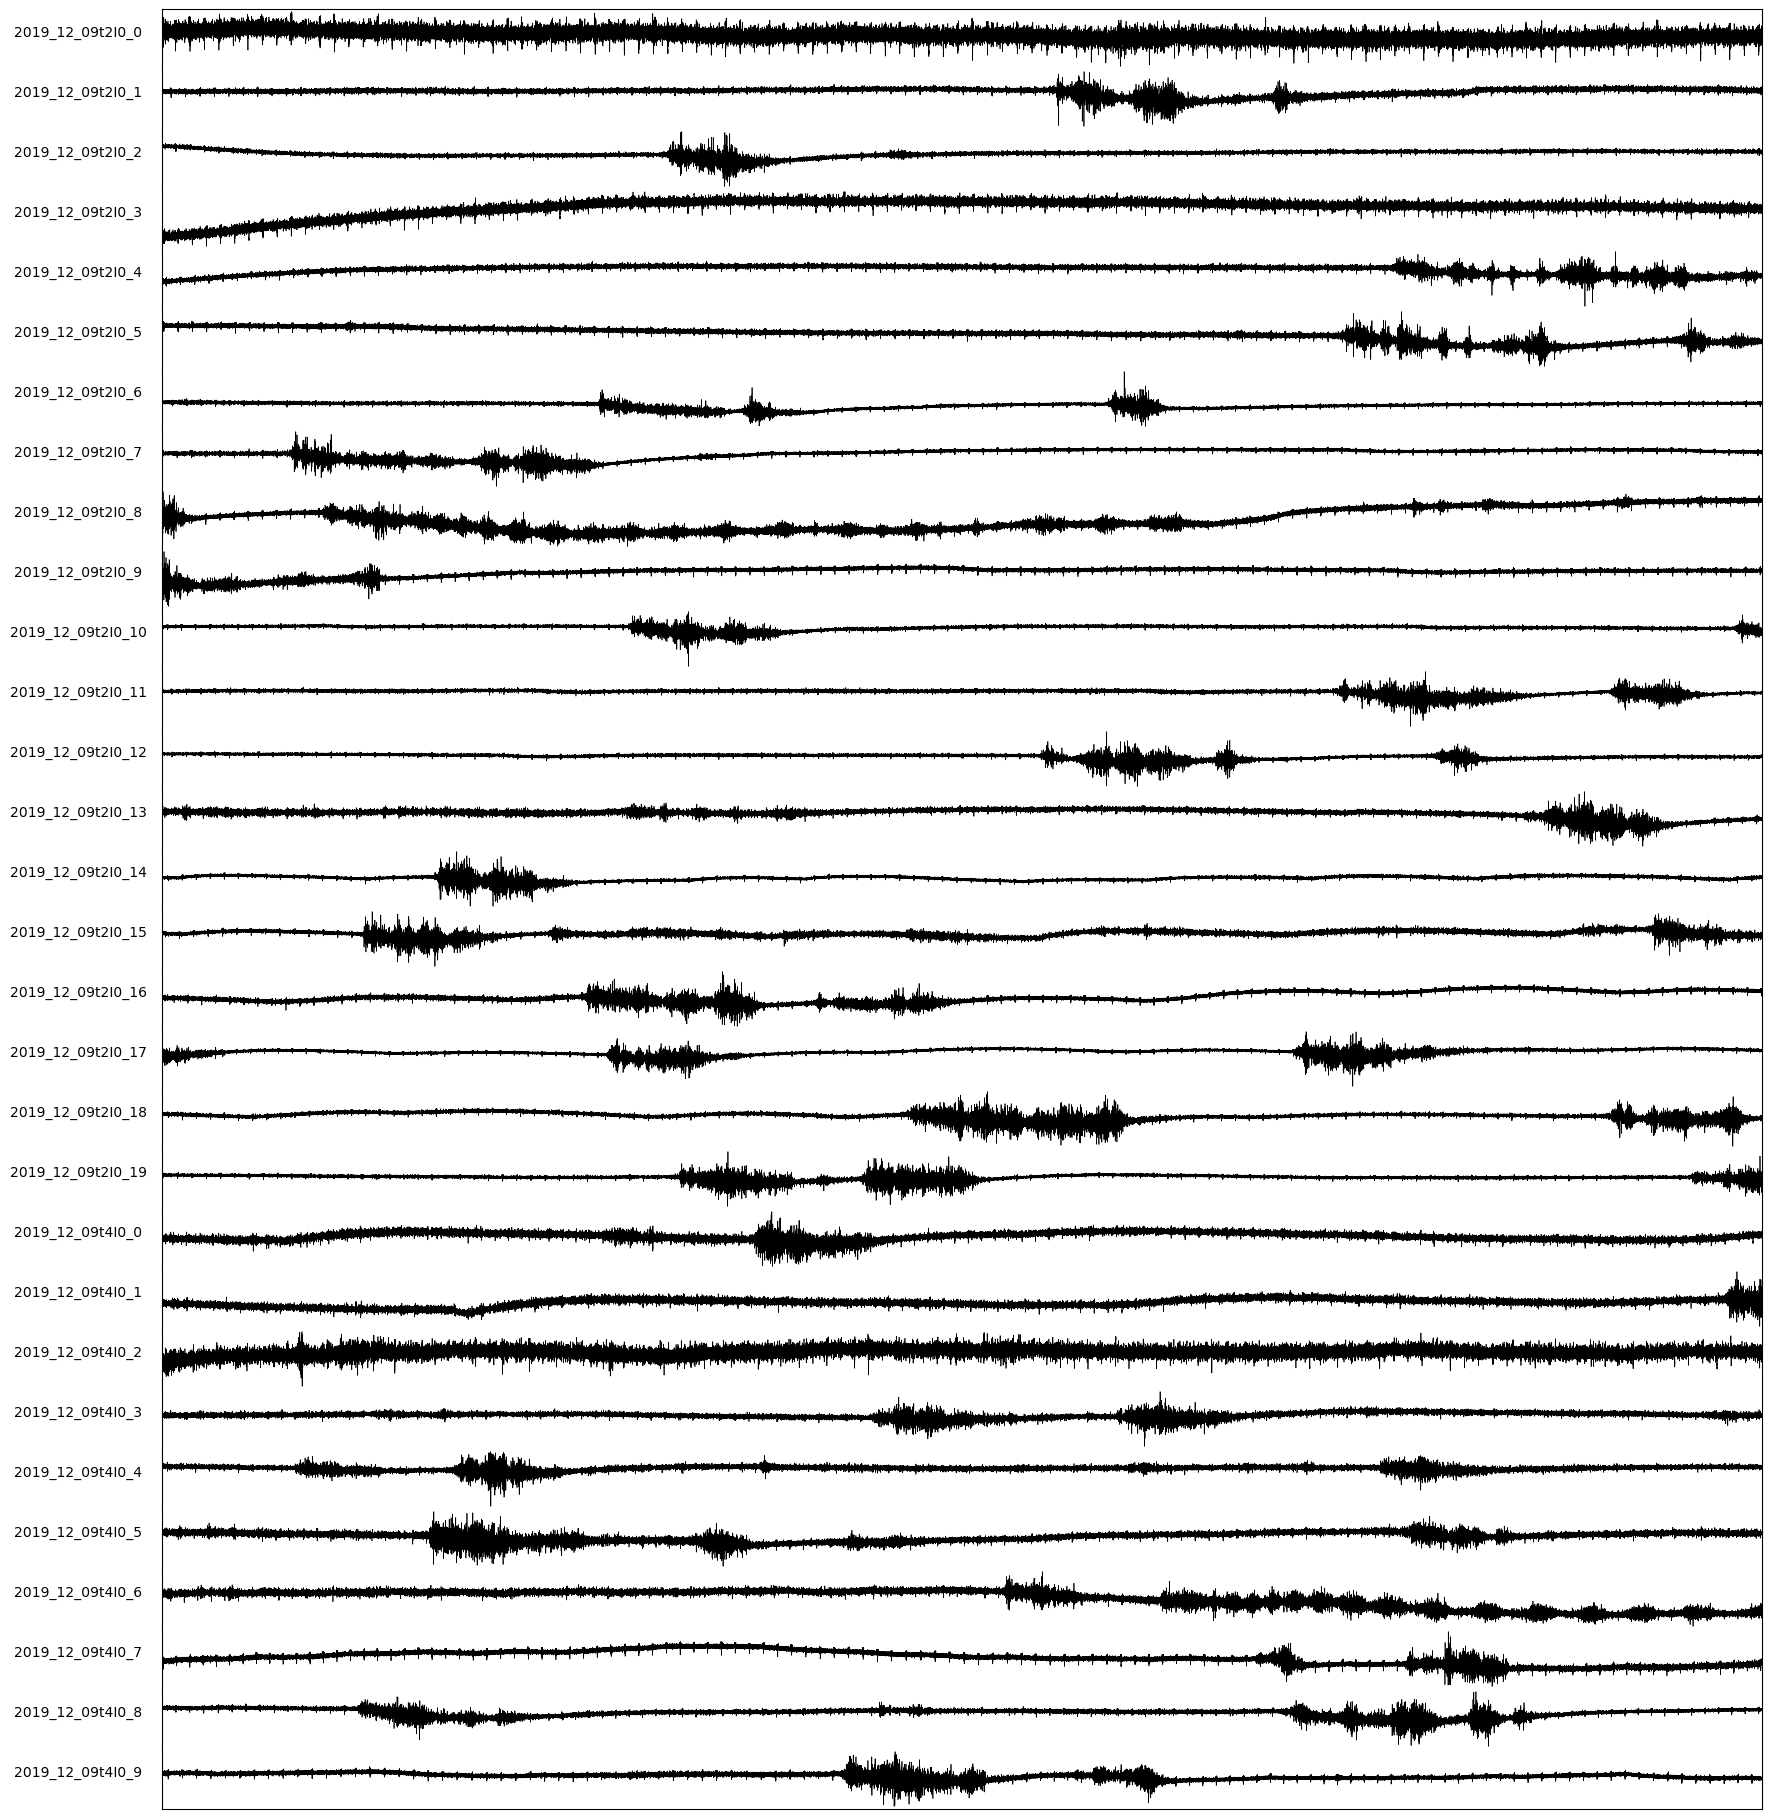

In [4]:
plot_channels(data = raw.get_data().T, time = raw.times, channels = channels, limit = None)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_55910/1935271028.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


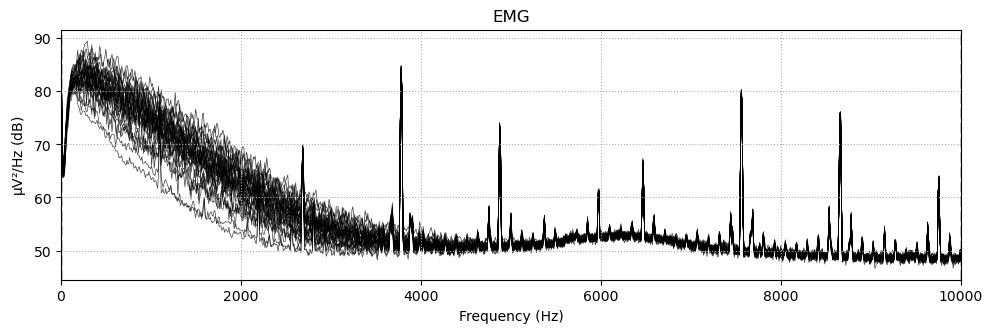

In [5]:
# Periodogram
raw.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [12]:
raw = pd.read_pickle('../output/spontaneous-movement/W1/C1/emg/filter.pkl')
channels = raw.ch_names

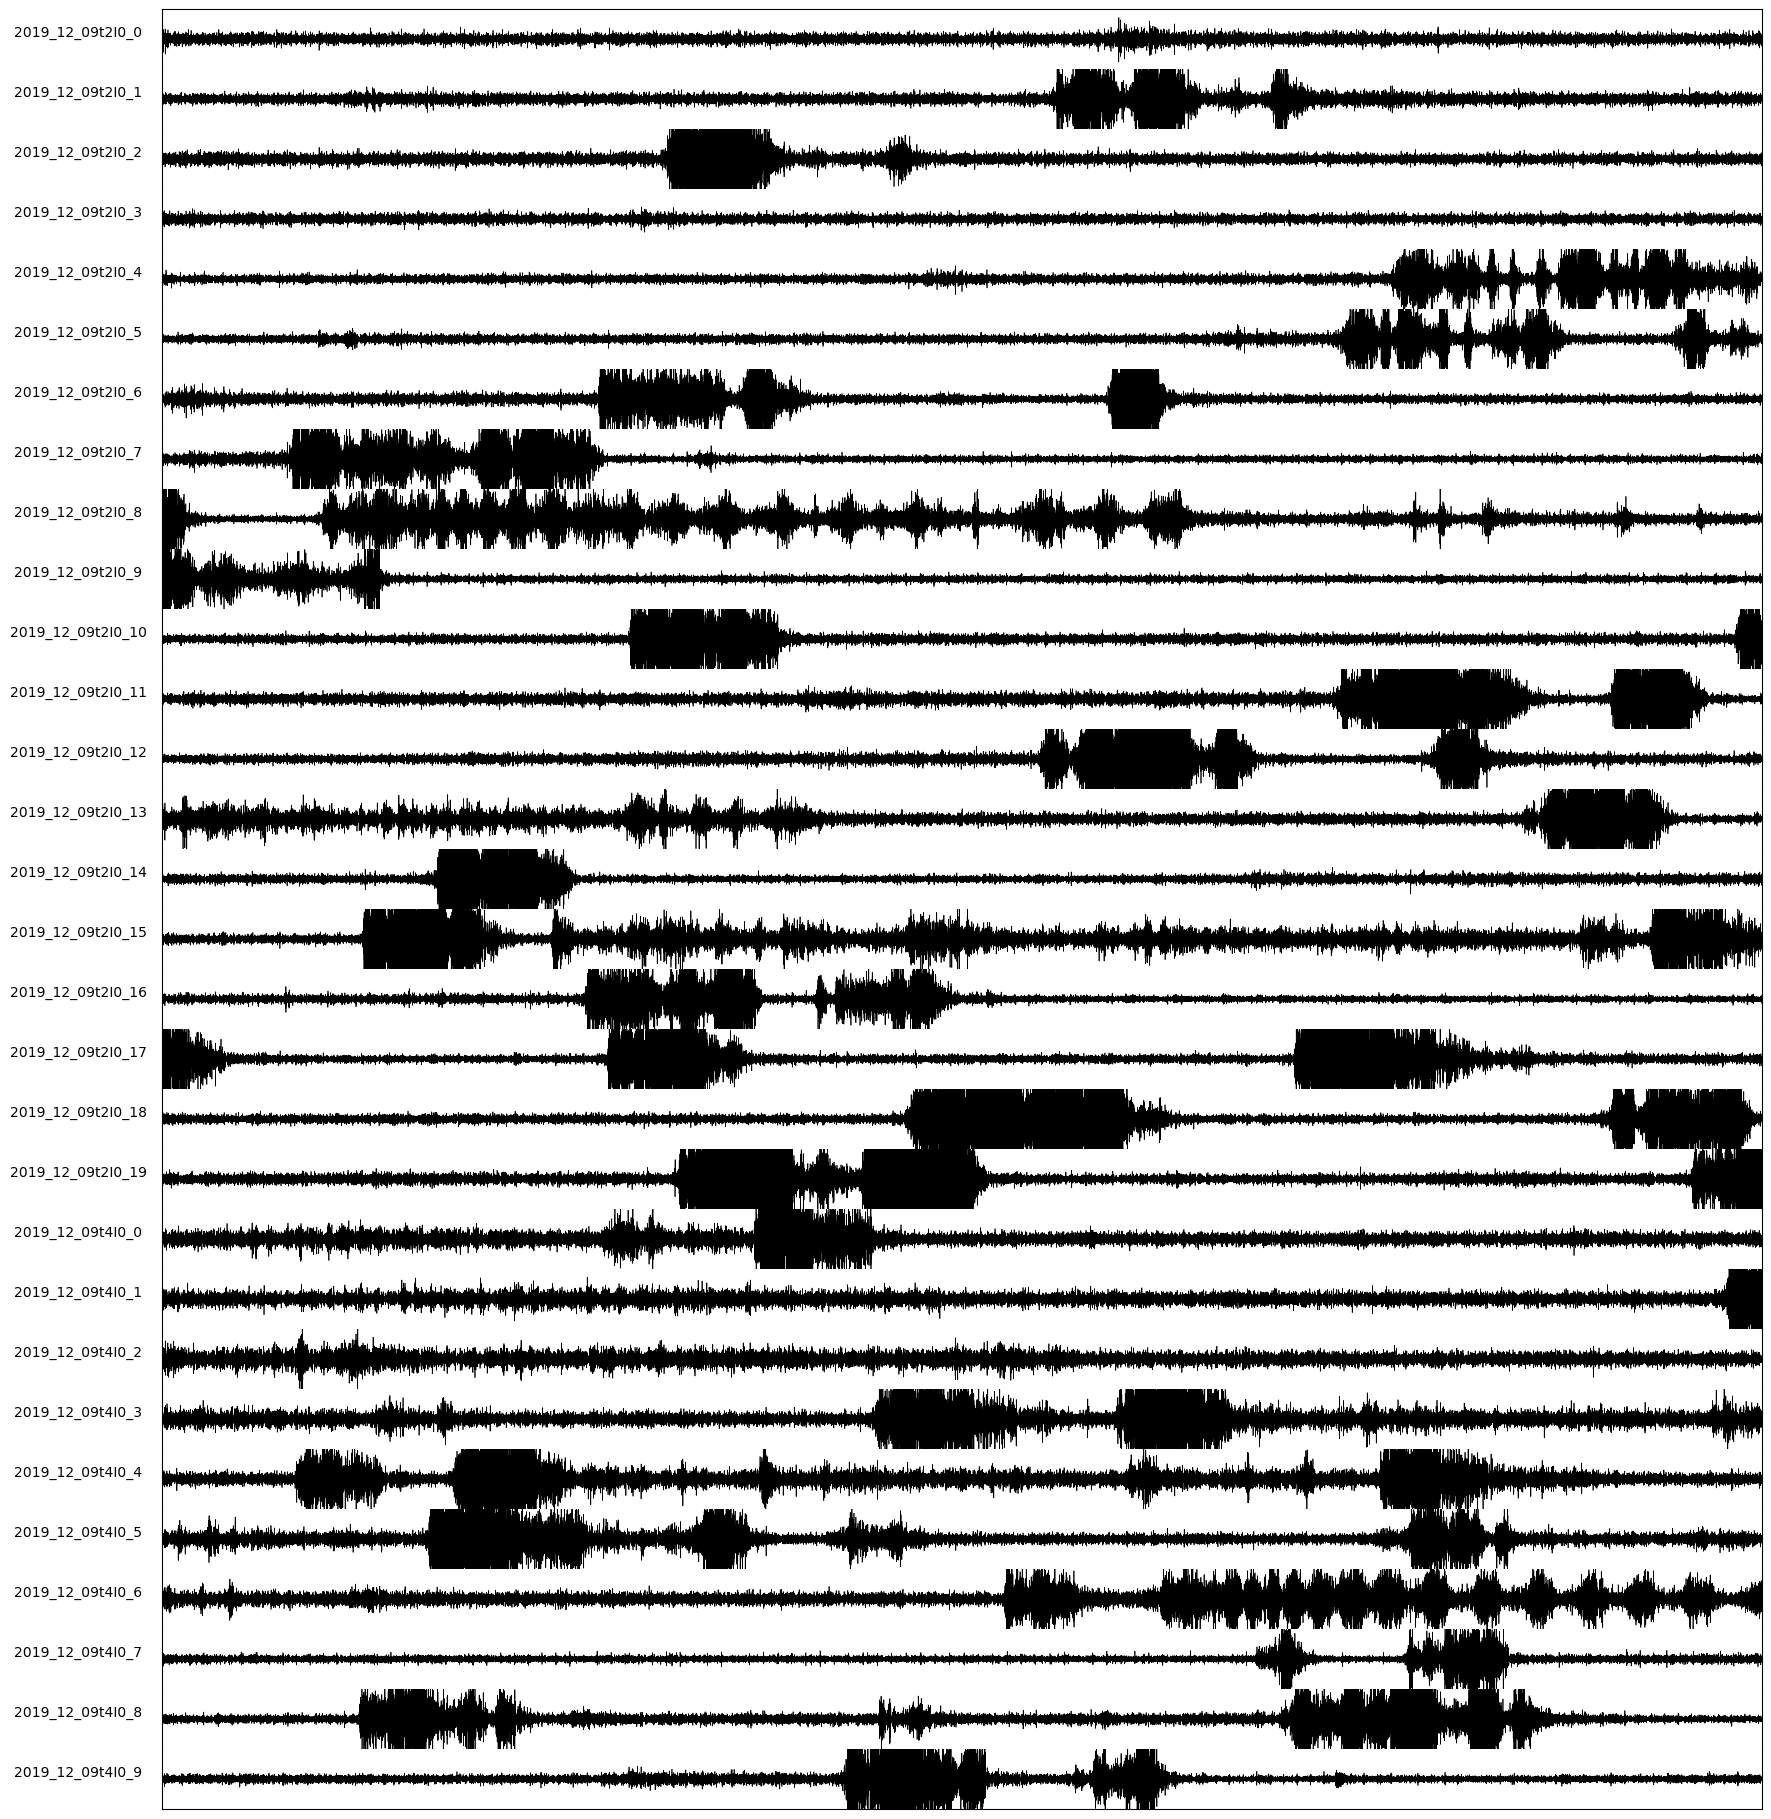

In [13]:
plot_channels(data = raw.get_data().T, time = raw.times, channels = channels, limit = 4)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_55910/3413662512.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = channels[0]).plot(picks = channels[0])
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


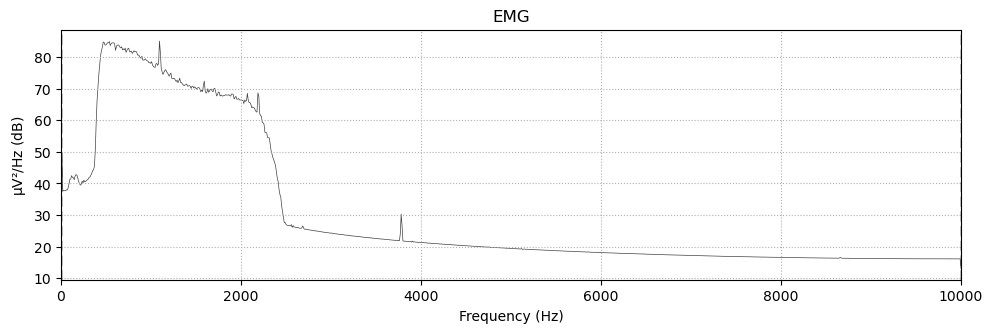

In [14]:
# Periodogram
raw.compute_psd(picks = channels[0]).plot(picks = channels[0])
plt.show()

## Teager-Kaiser Energy Operator

The Teager-Kaiser Energy Operator (TKEO) is used to improve the signal quality for onset movement detection. The formula for calculating the TKEO for any signal is as follows:

$$\Psi[x(n)] = x^2(n) - x(n + 1) \times x(n - 1)$$

In [15]:
def tkeo(signal):
    return signal[1:-1] ** 2 - signal[:-2] * signal[2:]

In [16]:
signal = raw.get_data(picks = [1])[0]

tke = tkeo(signal)
t = raw.times

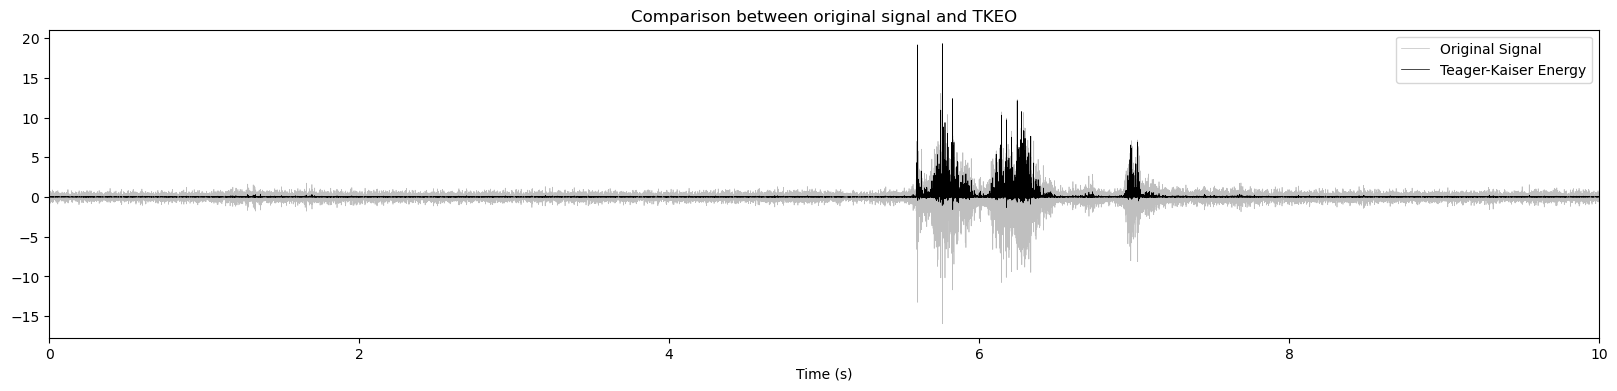

In [17]:
plt.figure(figsize = (20, 4))
plt.plot(t, signal, label = 'Original Signal', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.plot(t[1:-1], tke, label = 'Teager-Kaiser Energy', linewidth = 0.5, color = 'black')
plt.xlim(0, 10)
plt.xlabel('Time (s)')
plt.legend()
plt.title('Comparison between original signal and TKEO')
plt.show()

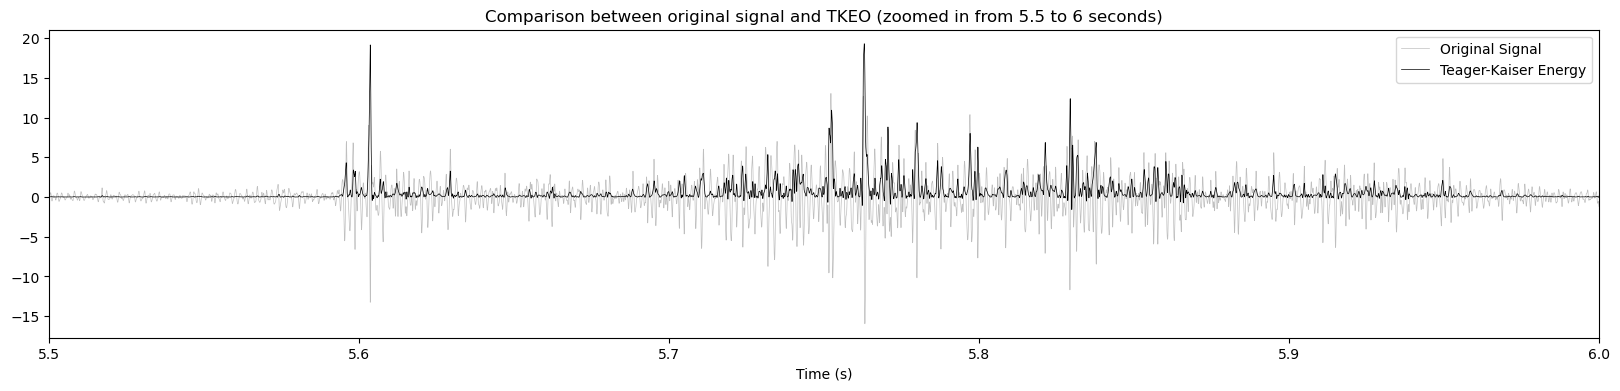

In [18]:
plt.figure(figsize = (20, 4))
plt.plot(t, signal, label = 'Original Signal', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.plot(t[1:-1], tke, label = 'Teager-Kaiser Energy', linewidth = 0.5, color = 'black')
plt.xlim(5.5, 6)
plt.xlabel('Time (s)')
plt.legend()
plt.title('Comparison between original signal and TKEO (zoomed in from 5.5 to 6 seconds)')
plt.show()

In [19]:
tke = []

for i, channel in enumerate(channels):
    signal = raw.get_data(picks = channel)[0]
    tke.append(tkeo(signal))

tke = np.array(tke).transpose()

ch_types = ['emg' for i in range(0, len(channels))]
info = mne.create_info(ch_names = channels, sfreq = sfreq, ch_types = ch_types)
tke = mne.io.RawArray(tke.T, info)

Creating RawArray with float64 data, n_channels=30, n_times=199999
    Range : 0 ... 199998 =      0.000 ...    10.000 secs
Ready.


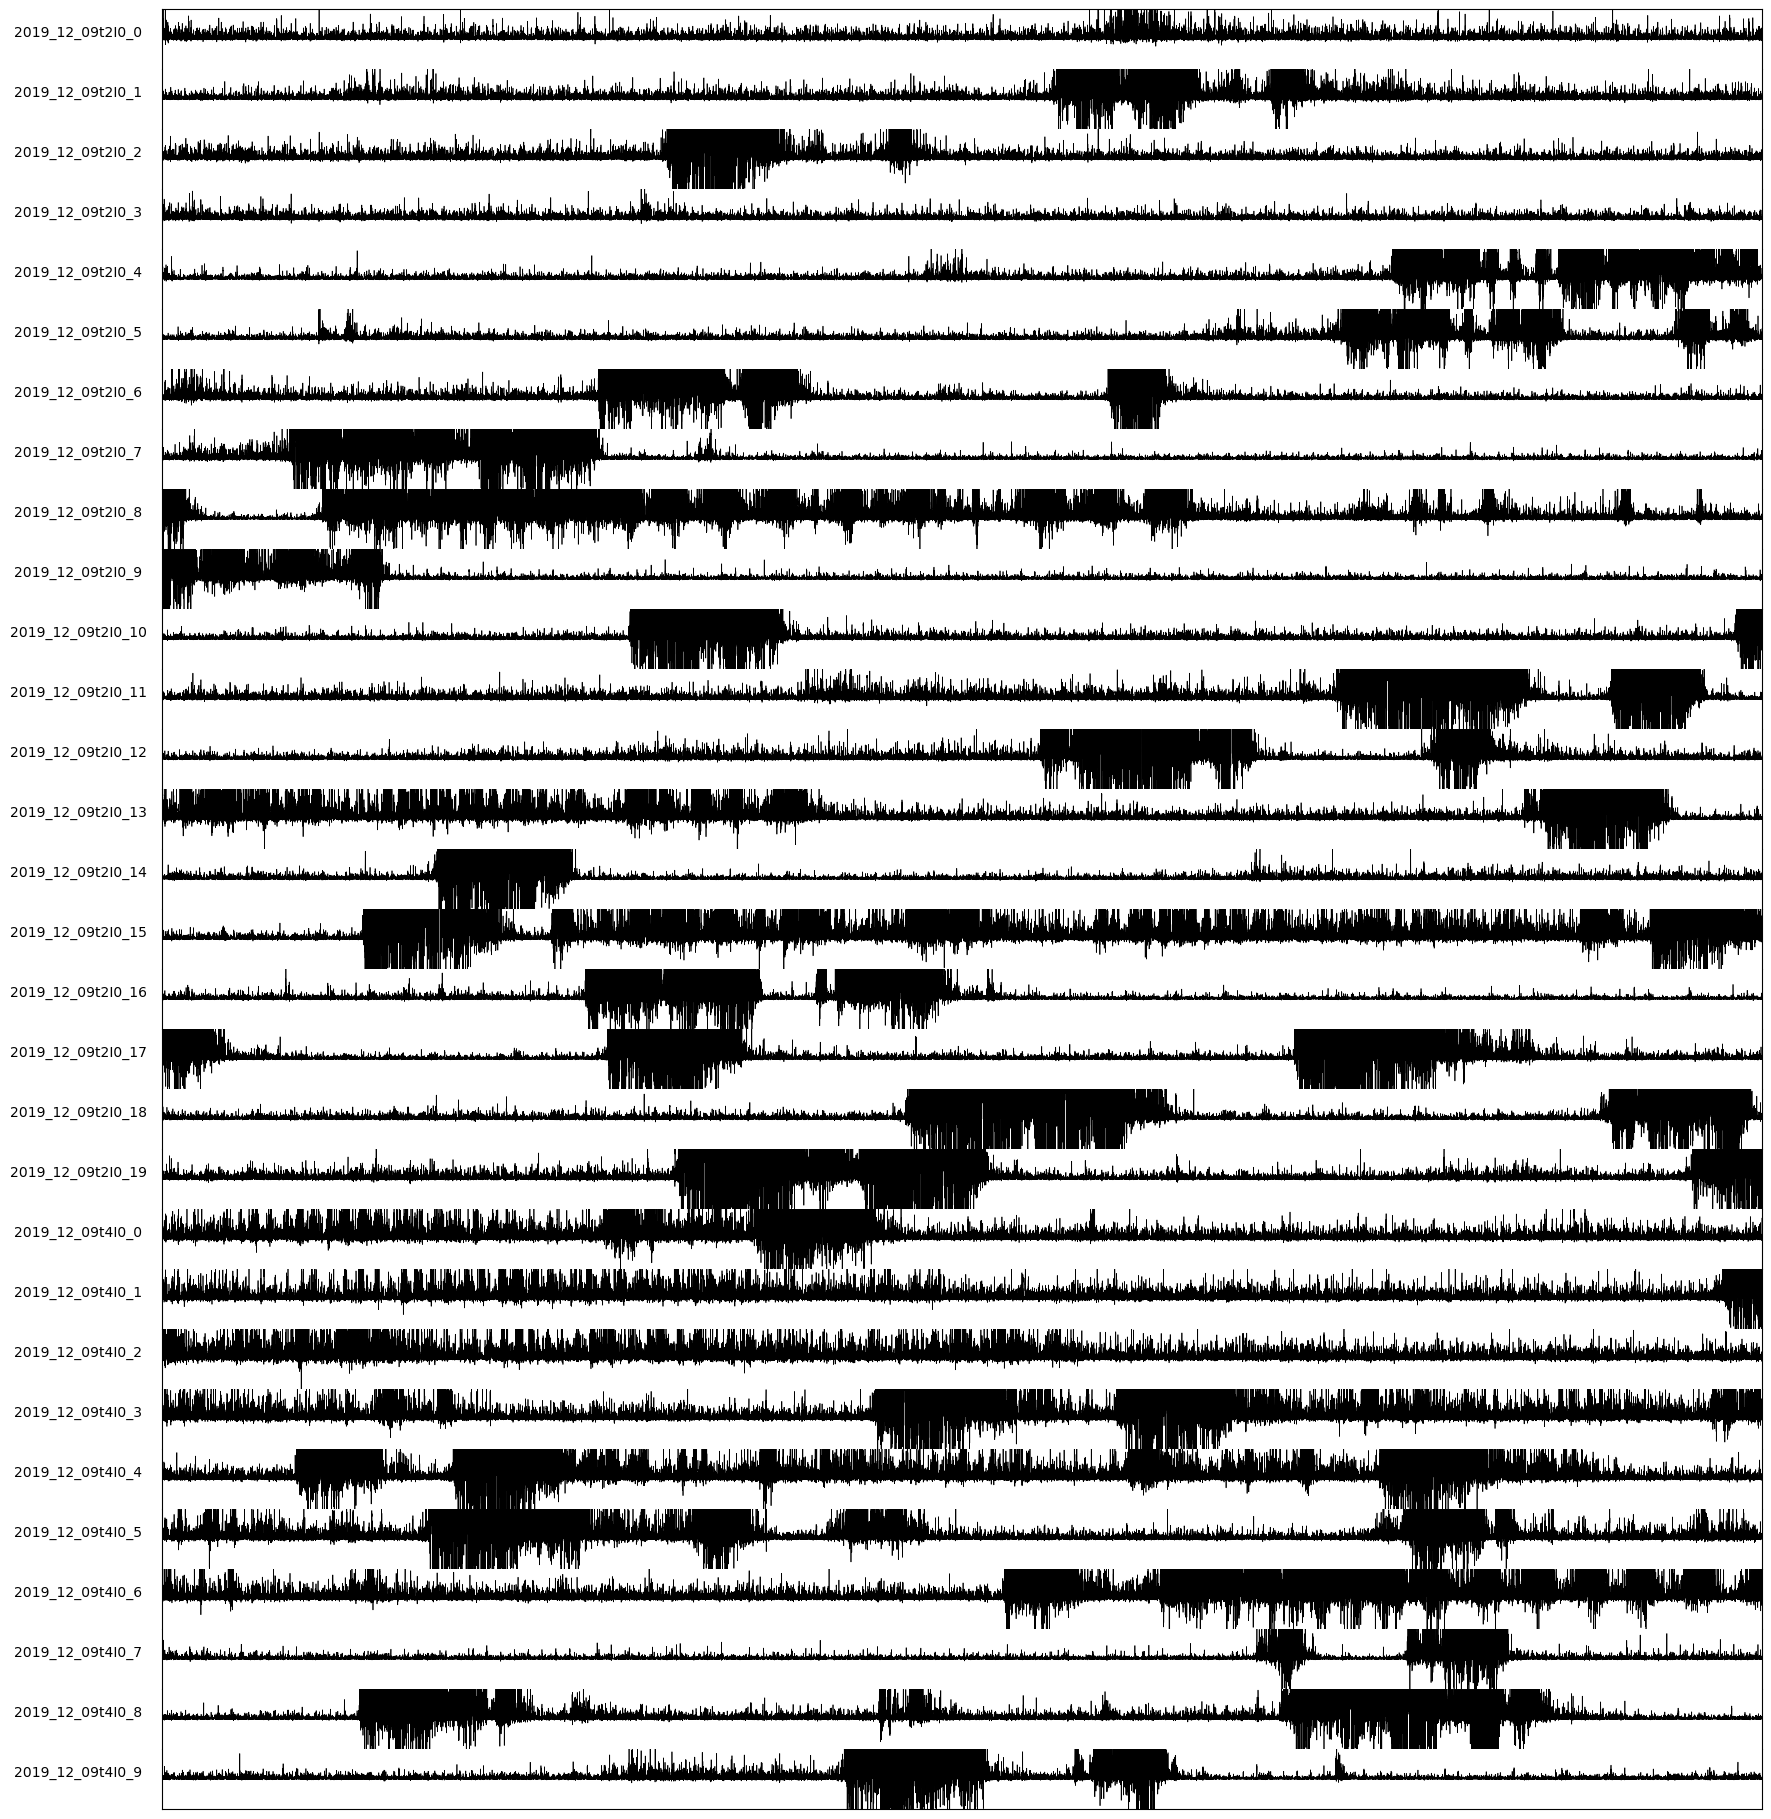

In [20]:
plot_channels(data = tke.get_data().T, time = tke.times, channels = channels, limit = 0.2)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_55910/525161481.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  tke.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


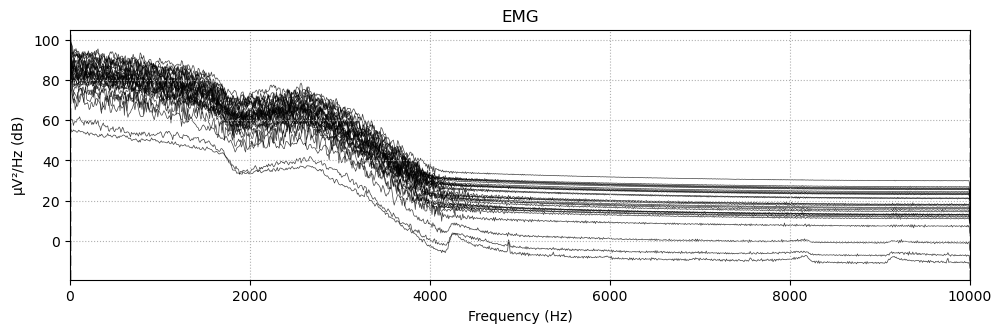

In [21]:
tke.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [22]:
tke.filter(l_freq = None, h_freq = 20, fir_design = 'firwin', picks = 'emg')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 13201 samples (0.660 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawArray | 30 x 199999 (10.0 s), ~45.8 MB, data loaded>

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_55910/525161481.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  tke.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


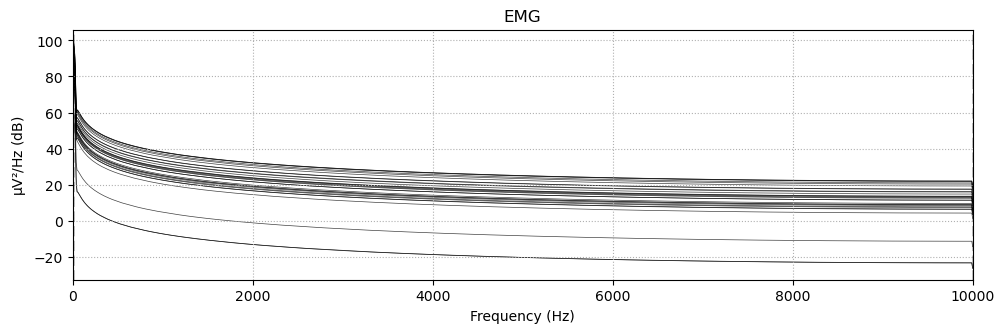

In [23]:
tke.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

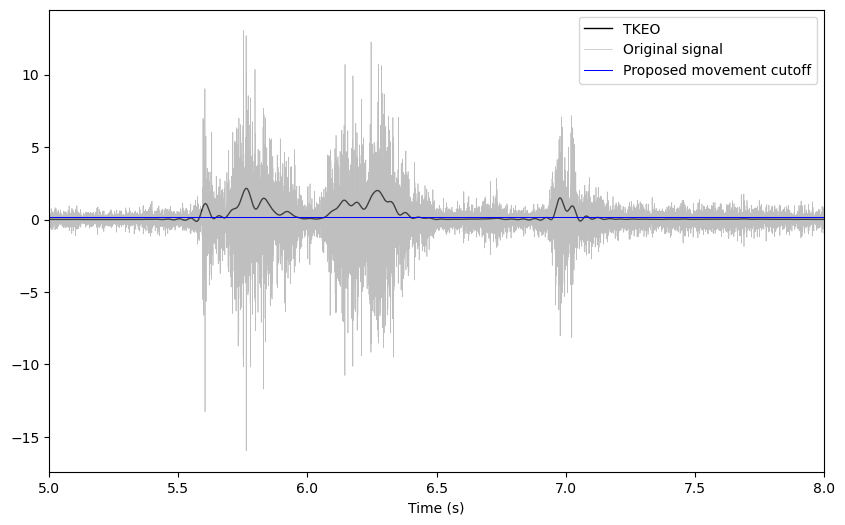

In [29]:
tke_signal = tke.get_data(picks = [1])[0]
tke_time = tke.times

signal = raw.get_data(picks = [1])[0]
signal_time = raw.times

plt.figure(figsize = (10, 6))
plt.plot(tke_time, tke_signal, linewidth = 1, color = 'black', label = 'TKEO')
plt.plot(signal_time, signal, linewidth = 0.5, color = 'gray', alpha = 0.5, label = 'Original signal')
plt.xlabel('Time (s)')
plt.xlim(5, 8)
plt.axhline(y = 0.15, color = 'blue', linestyle = '-', linewidth = 0.75, label = 'Proposed movement cutoff')
plt.legend()
plt.show()

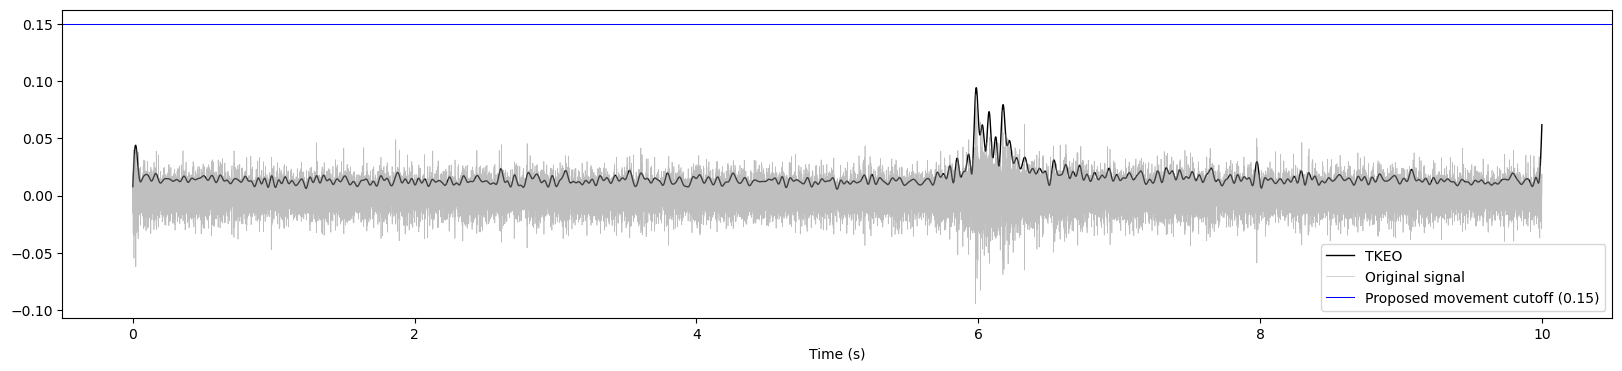

In [33]:
channel_i = 0

tke_signal = tke.get_data(picks = [channel_i])[0]
tke_time = tke.times

threshold = 0.15

move_events = extract_events(
    tkeo = tke_signal,
    sampling_rate = tke.info['sfreq'],
    threshold = threshold,
    min_event_length = 0.5,
    min_break = 0.1,
    expand_by = 0,
    extract_movement = True
)

signal = raw.get_data(picks = [channel_i])[0]

tke_range = np.max(np.abs(tke_signal))
normalized_signal = normalize(-tke_range, tke_range, signal)
signal_time = raw.times

plt.figure(figsize = (20, 4))
plt.plot(tke_time, tke_signal, linewidth = 1, color = 'black', label = 'TKEO')
plt.plot(signal_time, signal, linewidth = 0.5, color = 'gray', alpha = 0.5, label = 'Original signal')

has_label = False
for index, row in move_events.iterrows():
    start = row['EventStart']
    end = row['EventEnd']

    if has_label:
        plt.plot(tke_time[start:end], tke_signal[start:end], linewidth = 1, color = 'red')
    else:
        has_label = True
        plt.plot(tke_time[start:end], tke_signal[start:end], linewidth = 1, color = 'red', label = 'Movement')

# plt.xlim(5.5, 7.5)
plt.xlabel('Time (s)')
plt.axhline(y = threshold, color = 'blue', linestyle = '-', linewidth = 0.75,
            label = f'Proposed movement cutoff ({threshold})')
plt.legend()
plt.show()

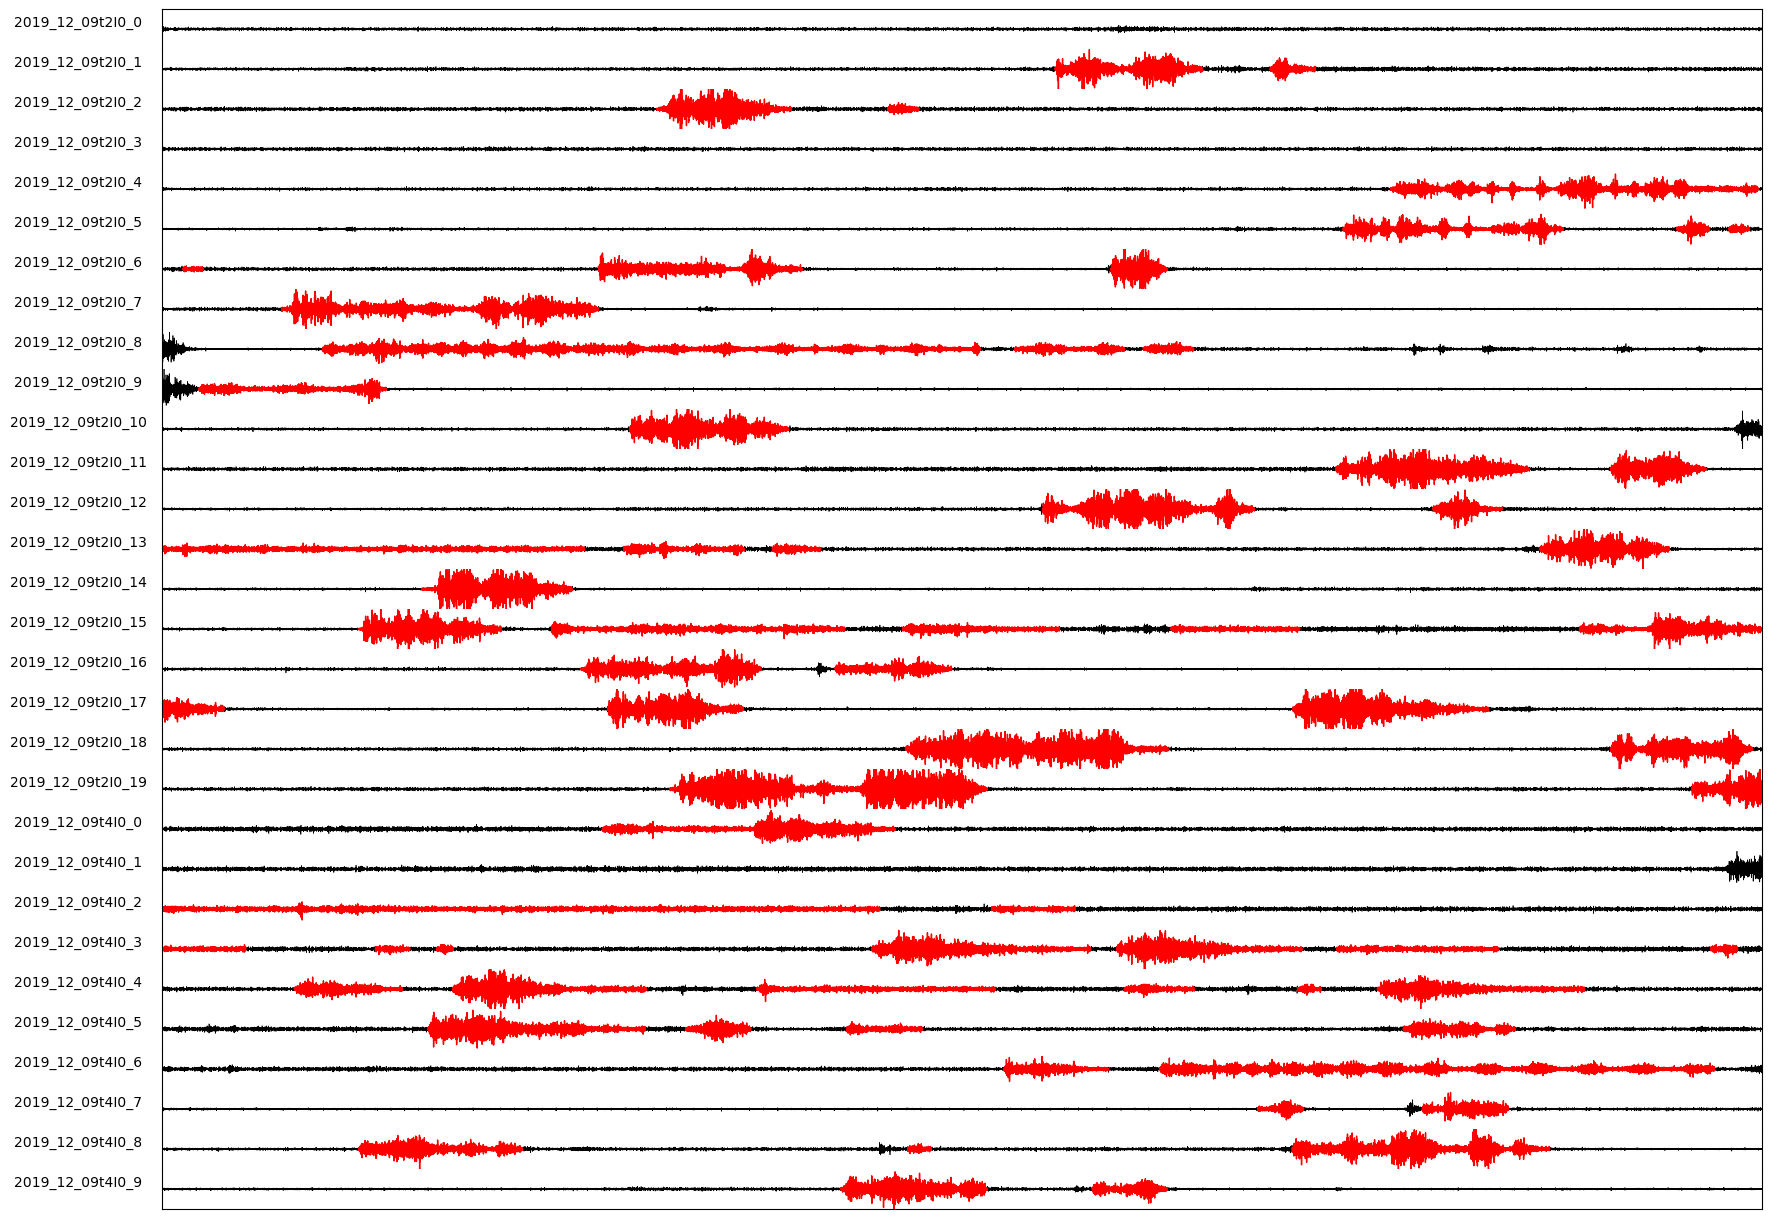

In [121]:
figure, axes = plt.subplots(nrows = len(channels), figsize = (20, 0.5 * len(channels)))
plt.subplots_adjust(
    left = 0.1,
    bottom = 0.1,
    right = 0.9,
    top = 0.9,
    wspace = 0,
    hspace = 0
)

x = raw.times

has_label = False

for i, channel in enumerate(channels):
    tke_signal = tke.get_data(picks = [i])[0]
    tke_time = tke.times

    move_events = extract_events(tke_signal, sampling_rate = sfreq, threshold = threshold, min_event_length = 0.1,
                                 min_break = 2000)

    y = raw.get_data(picks = [i])[0]

    axes[i].plot(x, y, linewidth = 0.5, color = 'black')
    axes[i].set_ylim(-4, 4)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    axes[i].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')
    axes[i].set_xlim(0, 10)

    for index, row in move_events.iterrows():
        start = row['EventStart']
        end = row['EventEnd']

        if has_label:
            axes[i].plot(x[start:end], y[start:end], linewidth = 1, color = 'red')
        else:
            has_label = True
            axes[i].plot(x[start:end], y[start:end], linewidth = 1, color = 'red', label = 'Movement')

    if i != 0:
        axes[i].spines['top'].set_visible(False)

    if i != len(channels) - 1:
        axes[i].spines['bottom'].set_visible(False)

plt.show()

In this step, the movement detection algorithm is more sensitive. The results will be filtered out later on to keep only good quality recordings.

Requirements for movement record:
- clear start phase (short time frame with no signal)
- clear (prolonged?) end phase
- strong average amplitude
- not too short, not too long

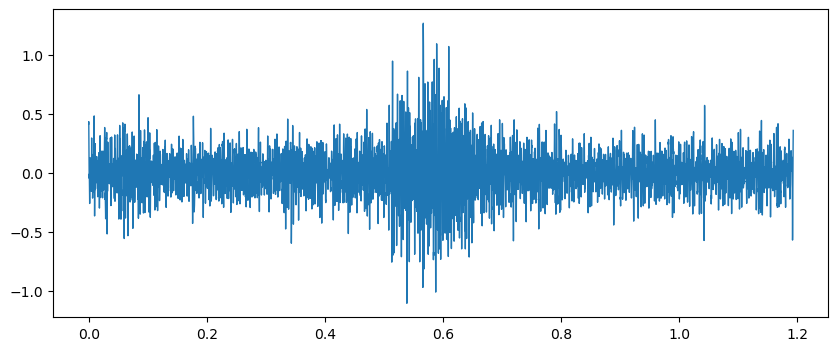

In [122]:
channel = 2
tke_signal = tke.get_data(picks = [channel])[0]
tke_time = tke.times

#
# Find movement events in this channel
#

move_events = extract_events(tke_signal, sampling_rate = sfreq, threshold = threshold, min_event_length = 0.1,
                             min_break = 2000)

#
# Extract a single movement data
#

start = move_events['EventStart'].iloc[1] / sfreq - 0.5
end = move_events['EventEnd'].iloc[1] / sfreq + 0.5

channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)

plt.figure(figsize = (10, 4))
plt.plot(channel_data.times, channel_data.get_data()[0], linewidth = 1)
plt.show()

In [123]:
event_id = 1

# Which time period before / after signal should be considered
calm_time = 0.25
# (Detection filter) Minimum movement signal amplitude
min_movement_amplitude = 0.5
# (Quality filter) Minimum difference between the amplitudes of calm vs movement
min_amplitude_difference = 0.5

In [124]:
start = move_events['EventStart'].iloc[event_id] / sfreq
end = move_events['EventEnd'].iloc[event_id] / sfreq
channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)
np.sqrt(np.mean(np.square(channel_data.get_data()[0])))

0.3182061247876038

In [125]:
start = move_events['EventStart'].iloc[event_id] / sfreq - calm_time
end = move_events['EventStart'].iloc[event_id] / sfreq
channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)
np.sqrt(np.mean(np.square(channel_data.get_data()[0])))

0.15883124970745352

In [126]:
start = move_events['EventEnd'].iloc[event_id] / sfreq
end = move_events['EventEnd'].iloc[event_id] / sfreq + calm_time
channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)
np.sqrt(np.mean(np.square(channel_data.get_data()[0])))

0.15068378630265283